In [4]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

In [5]:
# Load balanced CSV
df = pd.read_csv("../data/labels_balanced.csv")

# Make image paths absolute
df['image_path'] = df['image_path'].apply(lambda x: os.path.abspath(os.path.join("..", x)))

# Map labels to indices
label_map = {"Focused": 0, "Drifting": 1, "Lost": 2}
df['label_idx'] = df['label'].map(label_map)

# Split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label_idx'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label_idx'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Train distribution:\n{train_df['label'].value_counts()}")

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

# Class weights (should be ~1 since data is balanced)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label_idx']), y=train_df['label_idx'])
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Train: 2196, Val: 471, Test: 471
Train distribution:
label
Lost        732
Drifting    732
Focused     732
Name: count, dtype: int64
Found 2196 validated image filenames belonging to 3 classes.
Found 471 validated image filenames belonging to 3 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Build Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze base layers for initial training
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('../outputs/models/focus_model.h5', monitor='val_loss', save_best_only=True)

# --- Train ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

# --- Plot Accuracy & Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

KeyboardInterrupt: 

Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 383ms/step - accuracy: 0.9262 - loss: 0.1822 - val_accuracy: 0.9660 - val_loss: 0.0904
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.9668 - loss: 0.0695 - val_accuracy: 0.9597 - val_loss: 0.1120
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.9695 - loss: 0.0649 - val_accuracy: 0.7834 - val_loss: 0.6775
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 360ms/step - accuracy: 0.9709 - loss: 0.0620 - val_accuracy: 0.7219 - val_loss: 1.1328
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.9718 - loss: 0.0554 - val_accuracy: 0.9533 - val_loss: 0.1512


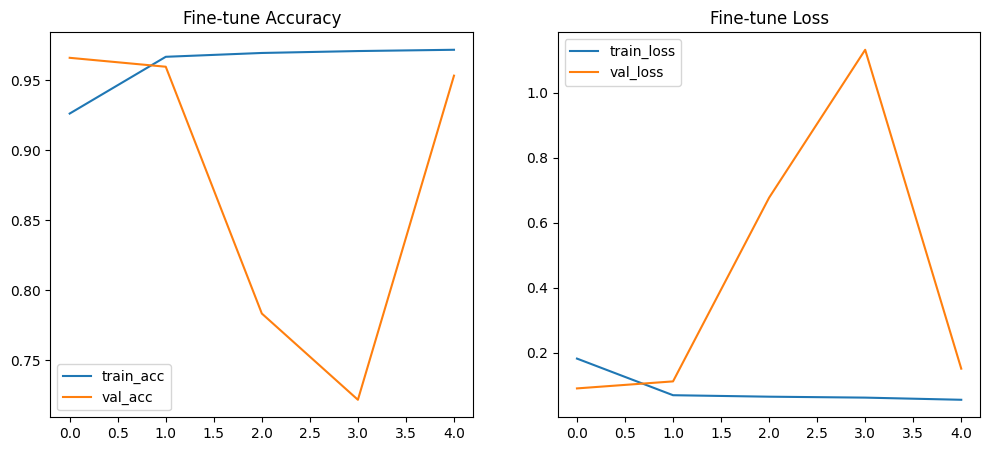

In [ ]:
# Fine-tune: Unfreeze some base layers
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

# Plot fine-tune
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='train_acc')
plt.plot(history_fine.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Fine-tune Accuracy')

plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Fine-tune Loss')
plt.show()